In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import os
import glob
import intake

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

In [2]:
path = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json'
col = intake.open_esm_datastore(path)
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,hfss,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,rsus,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,ts,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...


In [6]:
cat = col.search(activity_id='CMIP',
                 source_id='CESM2',
                 experiment_id='esm-hist',
                 table_id='Omon',
                 variable_id='fgco2',
                 member_id='r1i1p1f1',
                 grid_label='gn')
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,CMIP,NCAR,CESM2,esm-hist,r1i1p1f1,Omon,fgco2,gn,NaN,v20190802,185001-189912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
1,CMIP,NCAR,CESM2,esm-hist,r1i1p1f1,Omon,fgco2,gn,NaN,v20190802,190001-194912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
2,CMIP,NCAR,CESM2,esm-hist,r1i1p1f1,Omon,fgco2,gn,NaN,v20190802,195001-199912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
3,CMIP,NCAR,CESM2,esm-hist,r1i1p1f1,Omon,fgco2,gn,NaN,v20190802,200001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...


In [7]:
ds_dict = cat.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)


In [8]:
ds = ds_dict['CMIP.NCAR.CESM2.esm-hist.Omon.gn'].squeeze()
ds_hist = ds.sel(time=slice('1981-01', '2000-12'))

In [9]:
cat2 = col.search(activity_id='C4MIP',
                  source_id='CESM2',
                  experiment_id='esm-ssp585',
                  table_id='Omon',
                  variable_id='fgco2',
                  grid_label='gn')

In [11]:
ds_dictssp = cat2.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)


In [12]:
ds = ds_dictssp['C4MIP.NCAR.CESM2.esm-ssp585.Omon.gn'].squeeze()

In [13]:
ds_ssp = ds.sel(time=slice('2081-01', '2100-12'))

In [14]:
fgco2_hist = ds_hist['fgco2'].groupby('time.season').mean('time')
fgco2_ssp = ds_ssp['fgco2'].groupby('time.season').mean('time')
fgco2_ssp = fgco2_ssp.drop('member_id')
fgco2_anom = fgco2_ssp - fgco2_hist

/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/xarray/core/common.py:657: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/xarray/core/common.py:657: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [15]:
def plot_stereo(fig, axnum, data, seas):
    dplt = data.sel(season=seas)
    dplt = dplt[:100, :]
    axs = fig.add_subplot(4, 3, axnum, projection=ccrs.SouthPolarStereo())
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())
    im = dplt.plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label': 'kg m$^{-2}$ s$^{-1}$'})
    im.set_clim(-4e-9, 4e-9)
    
    if axnum == 1:
        axs.set_title('1981-2000')
    elif axnum == 2:
        axs.set_title('2081-2100')
    elif axnum == 3:
        axs.set_title('Anomaly')
    else:
        axs.set_title(' ')
    
    return im, axs

/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/apauling/miniconda3/env

Text(-0.1, 0.5, 'Spring (SON)')

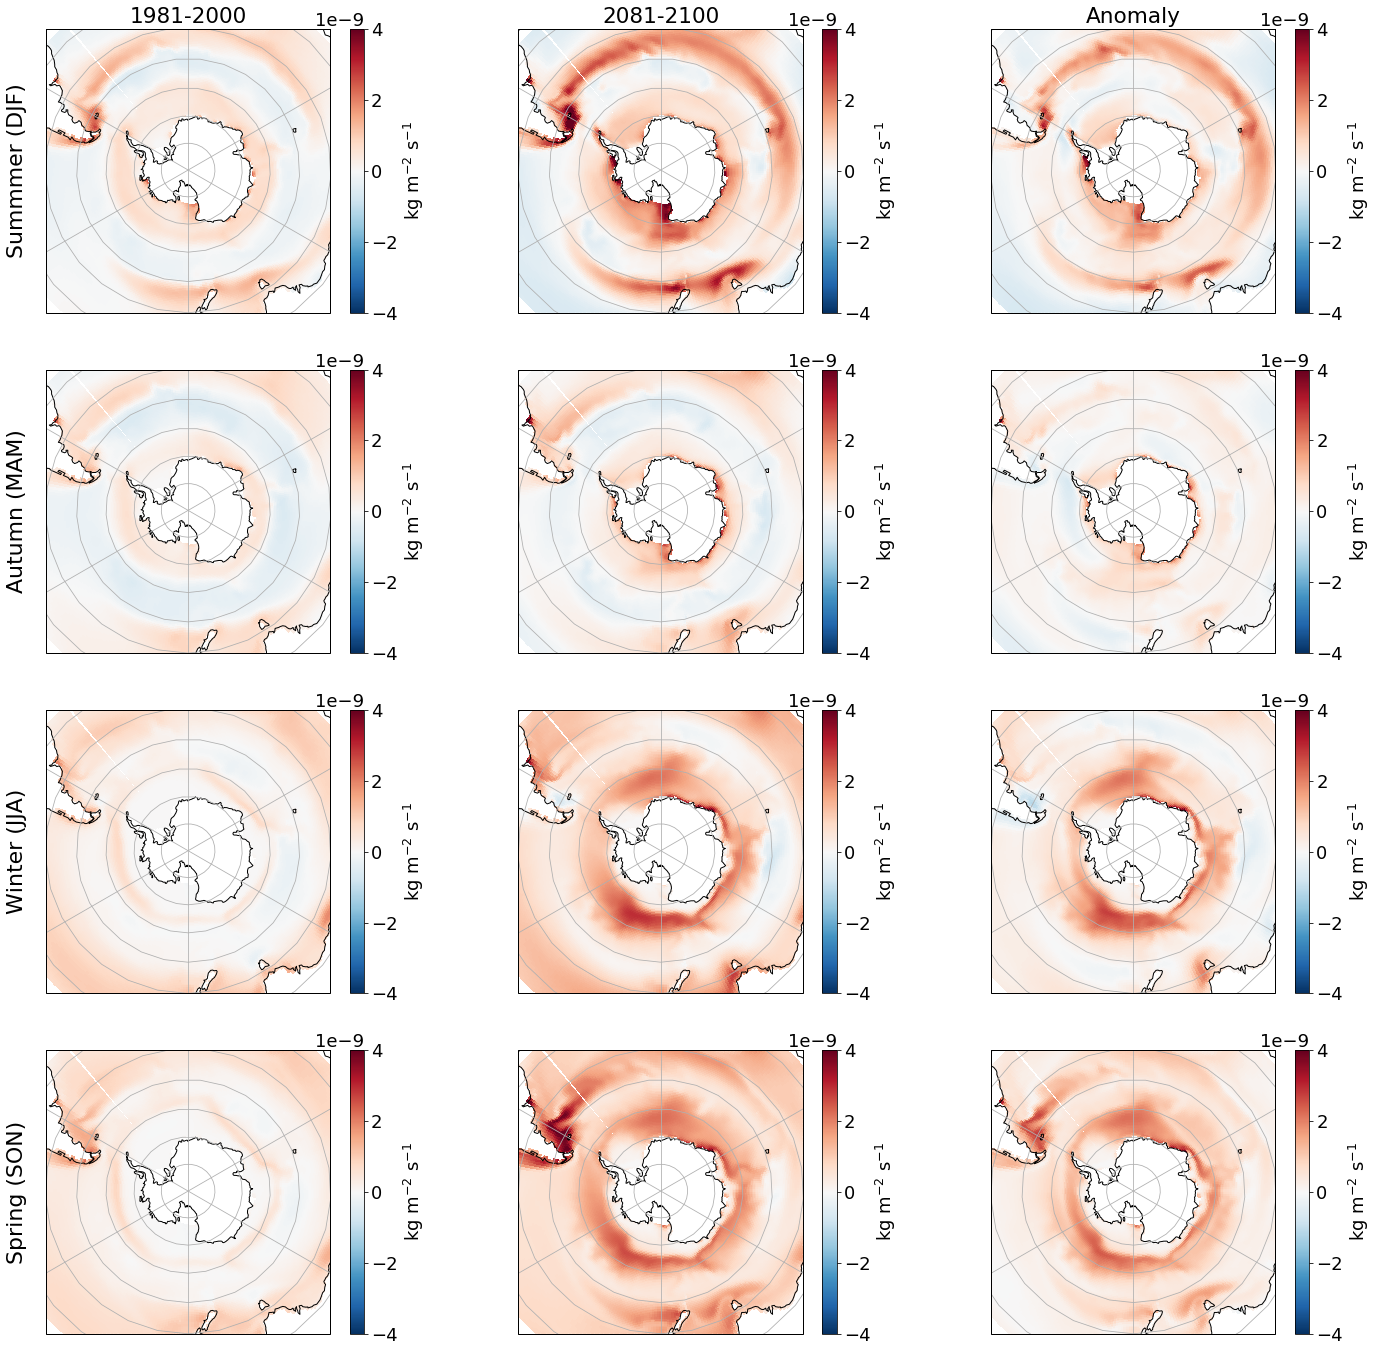

In [19]:
fig = plt.figure(1, figsize=(24, 24))
im1, ax1 = plot_stereo(fig, 1, fgco2_hist, 'DJF')
im2, ax2 = plot_stereo(fig, 2, fgco2_ssp, 'DJF')
im3, ax3 = plot_stereo(fig, 3, fgco2_anom, 'DJF')

im4, ax4 = plot_stereo(fig, 4, fgco2_hist, 'MAM')
im5, ax5 = plot_stereo(fig, 5, fgco2_ssp, 'MAM')
im6, ax6 = plot_stereo(fig, 6, fgco2_anom, 'MAM')

im7, ax7 = plot_stereo(fig, 7, fgco2_hist, 'JJA')
im8, ax8 = plot_stereo(fig, 8, fgco2_ssp, 'JJA')
im9, ax9 = plot_stereo(fig, 9, fgco2_anom, 'JJA')

im10, ax10 = plot_stereo(fig, 10, fgco2_hist, 'SON')
im11, ax11 = plot_stereo(fig, 11, fgco2_ssp, 'SON')
im12, ax12 = plot_stereo(fig, 12, fgco2_anom, 'SON')

ax1.annotate('Summmer (DJF)', xy=(-0.1, 0.5), xycoords='axes fraction',
            rotation=90, horizontalalignment='center',
            verticalalignment='center', fontsize=22)
ax4.annotate('Autumn (MAM)', xy=(-0.1, 0.5), xycoords='axes fraction',
            rotation=90, horizontalalignment='center',
            verticalalignment='center', fontsize=22)
ax7.annotate('Winter (JJA)', xy=(-0.1, 0.5), xycoords='axes fraction',
            rotation=90, horizontalalignment='center',
            verticalalignment='center', fontsize=22)
ax10.annotate('Spring (SON)', xy=(-0.1, 0.5), xycoords='axes fraction',
            rotation=90, horizontalalignment='center',
            verticalalignment='center', fontsize=22)

In [20]:
fig.savefig('../figures/co2/CESM2_fgco2_anomaly.png',
           bbox_inches='tight')